In [1]:
import os
import pandas as pd
import re
import json

In [ ]:
# Contry Codes to JSON
countries_dict = {
    "SP": 0,  # Spain
    "UK": 1,  # United Kingdom
    "DE": 2,  # Germany
    "DK": 3,  # Denmark
    "HU": 5,  # Hungary
    "SE": 4,  # Sweden
    "IT": 6,  # Italy
    "PO": 7,  # Poland
    "NL": 8   # Netherlands
}


In [ ]:
# Contry Codes to JSON
energy_types_dict = {
    "B01": "Biomass",
    "B02": "Fossil Brown coal/Lignite",
    "B03": "Fossil Coal-derived gas",
    "B04": "Fossil Gas",
    "B05": "Fossil Hard coal",
    "B06": "Fossil Oil",
    "B07": "Fossil Oil shale",
    "B08": "Fossil Peat",
    "B09": "Geothermal",
    "B10": "Hydro Pumped Storage",
    "B11": "Hydro Run-of-river and poundage",
    "B12": "Hydro Water Reservoir",
    "B13": "Marine",
    "B14": "Nuclear",
    "B15": "Other renewable",
    "B16": "Solar",
    "B17": "Waste",
    "B18": "Wind Offshore",
    "B19": "Wind Onshore",
    "B20": "Other",
    "B21": "AC Link",
    "B22": "DC Link",
    "B23": "Substation",
    "B24": "Transformer"
}


In [ ]:
# Directory where raw CSV files are stored
directory = "../jupyter_notebook/data_samples"
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
# List to hold all the dataframes
dataframes = []

# Iterate through all files in the directory
for filename in os.listdir(directory):

    if re.match(r'gen_[A-Z]{2}_[A-Z0-9]+\.csv', filename):

        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, filename), converters={'EndTime': date_parser}).set_index('EndTime')

        numeric_cols = df.select_dtypes(include=['number'])
        categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])

        # Resample the numeric columns and sum
        resampled_df_num = numeric_cols.resample('H').sum()

        # Resample the categorical columns.
        # Here, we take the first value. Adjust the method if needed (e.g., 'last', or a custom function to get the mode)
        resampled_df_cat= categorical_cols.resample('H').last()

        # Combine the resampled DataFrames back together
        resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)
       
        # Extract country and energy type from filename
        _, country, energy_type = filename.split('_')
        energy_type = energy_type.replace('.csv', '') # Remove the file extension

        # Add country and energy type as new columns
        resampled_df['CountryCode'] = country
        resampled_df['EnergyTypeCode'] = energy_type
        
        resampled_df = resampled_df.ffill()
        
        # Append the dataframe to the list
        dataframes.append(resampled_df)

# Concatenate all dataframes (if needed)
final_df = pd.concat(dataframes)

In [ ]:
# Map the energy type codes to full names
final_df['EnergyTypeName'] = final_df['EnergyTypeCode'].map(energy_types_dict)

In [ ]:
#Filter by R.Energy
energy_type_codes_to_filter = ['B01', 'B09', 'B10', 'B11', 'B12', 'B13', 'B15', 'B18', 'B19']

filtered_df = final_df[final_df['EnergyTypeCode'].isin(energy_type_codes_to_filter)]

In [ ]:
filtered_df.isna().sum()

In [ ]:
filtered_df.loc[filtered_df['StartTime'].isna(),'EnergyTypeCode'].unique()

In [ ]:
filtered_df.loc[filtered_df['StartTime'].isna(),'CountryCode'].unique()

In [ ]:
#Analisis porque no hay energia eolica en UK. (UK-B019)
import matplotlib.pyplot as plt

plt.plot(filtered_df.loc[(filtered_df['CountryCode']=='SE')&(filtered_df['EnergyTypeCode']=='B12'),'quantity'])
plt.show()

In [ ]:
#Analisis porque no hay energia eolica en UK. (UK-B019)
import matplotlib.pyplot as plt

plt.plot(filtered_df.loc[(filtered_df['CountryCode']=='UK')&(filtered_df['EnergyTypeCode']=='B19'),'quantity'])
plt.show()

In [ ]:
filtered_df

In [ ]:
final_df['CountryCode'].value_counts()

In [ ]:
dic['UK'] = dic['UK'].ffill()

In [ ]:
dic['UK'] #2022-01-27 01:00:00+00:00

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dic['UK']['quantity'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dic['SE']['quantity'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dic['SE']['quantity'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dic['DE']['quantity'])
plt.show()

In [ ]:
final_df.isna().sum()

In [ ]:
final_df.loc[final_df['StartTime'].isna(),'CountryCode']

In [ ]:
final_df.loc[final_df['StartTime'].isna(),'EnergyTypeCode'].value_counts()

In [ ]:
final_df

Thank you for providing more details about your dataset. Based on your description, it seems that you have a DataFrame indexed by datetime, with columns for start time, unit name, PSR type, and quantity. The goal is to forecast the 'quantity' for the missing months (May to September).

### Steps for Forecasting

#### 1. Data Preprocessing
- **Convert 'StartTime' to DateTime**: If not already in `datetime` format, convert the 'StartTime' column to a datetime object using `pd.to_datetime()`.
- **Set 'StartTime' as Index**: If not already set, consider setting 'StartTime' as the DataFrame index for easier time series analysis.
- **Check for Missing Dates**: Ensure that all dates and times are represented. If there are missing intervals, decide how to handle them (e.g., filling with NaNs).
- **Aggregating Data**: Depending on the granularity you need, you might consider aggregating your data (e.g., daily average). 

#### 2. Exploratory Data Analysis
- **Plotting the Series**: Visualize the 'quantity' over time to understand patterns, trends, and seasonality.
- **Seasonality and Trend Analysis**: Check if there is any visible seasonality or trend in the data which might influence the choice of the model.

#### 3. Model Selection
Given the nature of your data, you might consider the following models:
- **ARIMA/SARIMA**: If your data shows trends or autocorrelation. SARIMA is suitable if there is a clear seasonal pattern.
- **Prophet**: Handles daily data well, robust to missing data, and good with seasonality.
- **Machine Learning Approaches**: If there are other factors that can predict 'quantity', a model like Random Forest or Gradient Boosting might be useful.

#### 4. Model Training and Forecasting
- **Training**: Use data from January to April and October to December.
- **Forecasting**: Generate predictions for the missing months.
- **Hyperparameter Tuning**: Optimize model parameters for best performance.

#### 5. Model Evaluation
- **Performance Metrics**: Evaluate the model using appropriate metrics.
- **Cross-Validation**: If possible, use time series cross-validation.

#### 6. Implementation
Here are some Python libraries you might find useful:
- `pandas` for data manipulation.
- `matplotlib` or `seaborn` for data visualization.
- `statsmodels` for ARIMA/SARIMA models.
- `fbprophet` for the Prophet model.
- `scikit-learn` for machine learning models.

Would you like a specific example on how to implement any of these models in Python, or do you have any specific questions about any of the steps?

In [24]:
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
df = pd.read_csv("../jupyter_notebook/data_samples/gen_UK_B19.csv", converters={'EndTime': date_parser}).set_index('EndTime')

In [25]:
df.drop(columns=['AreaID', 'StartTime'], inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12644 entries, 2022-01-27 00:00:00+00:00 to 2022-12-31 23:30:00+00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UnitName  12644 non-null  object
 1   PsrType   12644 non-null  object
 2   quantity  12644 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 395.1+ KB


In [27]:
# Truncate or round the datetime index to hourly
df_hourly = df.resample('H').sum()

In [28]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8136 entries, 2022-01-27 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Freq: H
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UnitName  8136 non-null   object
 1   PsrType   8136 non-null   object
 2   quantity  8136 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 254.2+ KB


In [29]:
import matplotlib.pyplot as plt

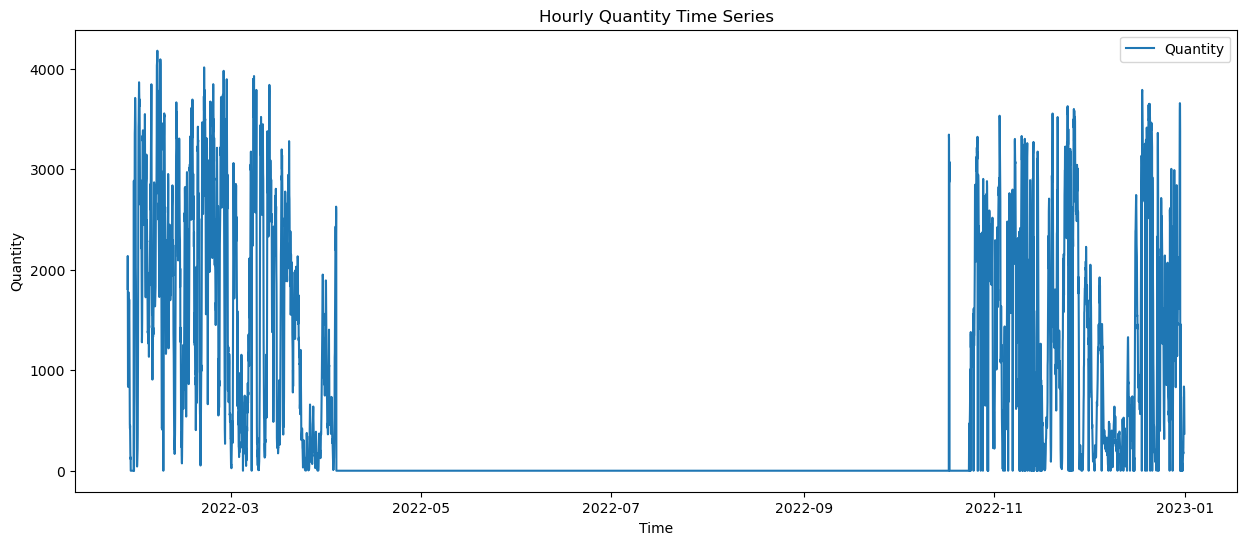

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(df_hourly['quantity'], label='Quantity')
plt.title('Hourly Quantity Time Series')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [31]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

p = 1  # replace with actual
d = 1  # replace with actual
q = 1  # replace with actual

# Fit the ARIMA model (using the known part of the time series)
model = ARIMA(df['quantity'], order=(p, d, q))
model_fit = model.fit()

# Forecast the missing values
# The 'steps' argument would be the number of hours in the missing months
forecast = model_fit.get_forecast(steps=4350) #hours in a monyh

# The forecast object contains the predicted values and other information
forecasted_values = forecast.predicted_mean

# You may also want to extract the confidence intervals of the forecasts
conf_int = forecast.conf_int()

# Do something with the forecasted values, like plotting them or inserting them back into your DataFrame


c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

To choose appropriate parameters for an ARIMA model, you can follow these steps:

1. Stationarity Check
First, check if your time series is stationary. This can be done using a statistical test, such as the Augmented Dickey-Fuller (ADF) test.

2. Differencing
If the time series is not stationary, apply differencing (d parameter in ARIMA) to make it stationary.

3. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
Once you have a stationary series, plot the ACF and PACF. These plots will help you determine the p and q parameters.

ACF: Helps to identify the Moving Average (MA) component, which corresponds to q.
PACF: Helps to identify the Autoregressive (AR) component, which corresponds to p.
4. Model Identification
Based on the ACF and PACF plots, you can identify initial values for p and q:

The lag where the PACF cuts off is the estimated p.
The lag where the ACF cuts off is the estimated q.
5. Iterative Process
Model selection is an iterative process. You may need to try different combinations of p, d, and q and use model selection criteria like AIC (Akaike Information Criterion) to find the best model.

ADF Statistic: -9.277503
p-value: 0.000000


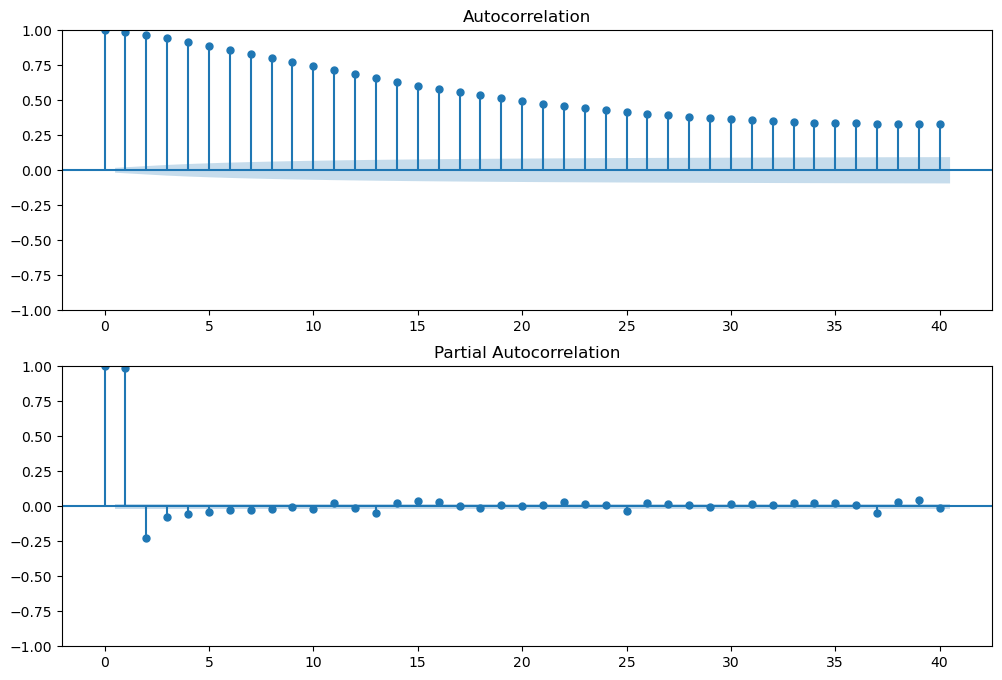

c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pablo\.conda\envs\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                12644
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -65991.736
Date:                Sat, 18 Nov 2023   AIC                         131995.471
Time:                        13:24:25   BIC                         132040.141
Sample:                             0   HQIC                        132010.417
                              - 12644                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        398.6931     20.920     19.058      0.000     357.691     439.695
ar.L1          1.7918      0.022     83.084      0.000       1.750       1.834
ar.L2         -0.7992      0.021    -37.809      0.0

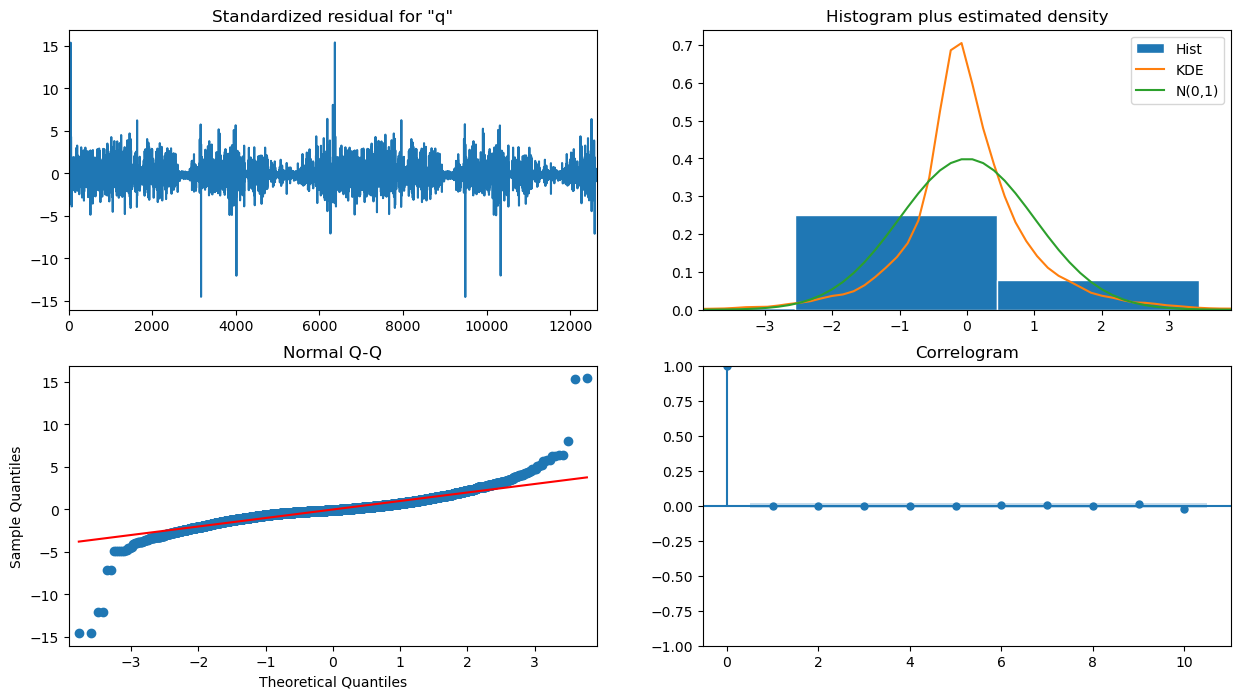

In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load your data
# Assuming 'df' is your DataFrame with 'quantity' after loading your data

# Check for stationarity
result = adfuller(df['quantity'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# If p-value > 0.05, the series is not stationary and you need to difference it

# Apply differencing if needed and determine 'd'
if result[1] > 0.05:
    # Assuming one level of differencing makes the series stationary
    d = 1
    df['quantity_diff'] = df['quantity'].diff(periods=d).dropna()
else:
    d = 0
    df['quantity_diff'] = df['quantity']

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['quantity_diff'], lags=40, ax=ax1)  # Change lags as needed
plot_pacf(df['quantity_diff'], lags=40, ax=ax2)  # Change lags as needed
plt.show()

# Look at where the plots cross the significance level for the first time to estimate 'p' and 'q'
# These are initial estimates and might need to be refined

# For example, if PACF cuts off after lag 2, and ACF tails off slowly, you might start with:
p = 2
q = 2

# Try fitting an ARIMA model with the initial parameters
model = sm.tsa.arima.ARIMA(df['quantity'], order=(p, d, q))
model_fit = model.fit()

# Evaluate model - check the AIC and the residual plots
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

# You may need to refine your (p, d, q) based on the diagnostics and AIC values


In [ ]:
# Directory where raw CSV files are stored
directory = "../jupyter_notebook/data_samples"
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
# List to hold all the dataframes
dataframes = []

# Iterate through all files in the directory
for filename in os.listdir(directory):

    if re.match(r'gen_[A-Z]{2}_[A-Z0-9]+\.csv', filename):

        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, filename), converters={'EndTime': date_parser}).set_index('EndTime')

        numeric_cols = df.select_dtypes(include=['number'])
        categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])

        # Resample the numeric columns and sum
        resampled_df_num = numeric_cols.resample('H').sum()

        # Resample the categorical columns.
        # Here, we take the first value. Adjust the method if needed (e.g., 'last', or a custom function to get the mode)
        resampled_df_cat= categorical_cols.resample('H').last()

        # Combine the resampled DataFrames back together
        resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)
       
        # Extract country and energy type from filename
        _, country, energy_type = filename.split('_')
        energy_type = energy_type.replace('.csv', '') # Remove the file extension

        # Add country and energy type as new columns
        resampled_df['CountryCode'] = country
        resampled_df['EnergyTypeCode'] = energy_type
        
        resampled_df = resampled_df.ffill()
        
        # Append the dataframe to the list
        dataframes.append(resampled_df)

# Concatenate all dataframes (if needed)
final_df = pd.concat(dataframes)